# Find connections within your field of research papers

The idea is to retrieve Mendeley documents from my personal database and then process it to show connections between authors into my bibliography.

I used NetworkX but a better alternative (but more complex) is to use https://graph-tool.skewed.de/.

At the end of the process, I export my graph into a GraphML file so I can open it with Cytoscape designed to perform complex visual data analysis (http://www.cytoscape.org/).

In [1]:
%matplotlib inline

import os
import sys
import itertools
from difflib import SequenceMatcher

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import networkx as nx

from mendeley import Mendeley
from requests_oauthlib import OAuth2Session
from mendeley.session import MendeleySession

# Parameters

Put your **client ID** in **client secret** here. You can generate them from http://dev.mendeley.com/myapps.html.

In [2]:
client_id = "XXX"
client_secret = "XXXXXXXX"

# Get authors data from Mendeley API

In [3]:
redirect_uri = 'https://localhost'

authorization_base_url = "https://api.mendeley.com/oauth/authorize"
token_url = "https://api.mendeley.com/oauth/token"

scope = ['all']

oauth = OAuth2Session(client_id, redirect_uri=redirect_uri, scope=scope)

authorization_url, state = oauth.authorization_url(authorization_base_url,
                                                   access_type="offline",
                                                   approval_prompt="force")

print('Please go to {} and authorize access.'.format(authorization_url))

Please go to https://api.mendeley.com/oauth/authorize?response_type=code&client_id=1821&redirect_uri=https%3A%2F%2Flocalhost&scope=all&state=cZWcF72zc0ylWjIKSCZUabUBdluVoL&approval_prompt=force&access_type=offline and authorize access.


## Paste the fallback url here

In [4]:
authorization_code = "https://localhost/?code=x4Ca_7i3tLPdlk9VcuVV-j5UeKA&state=cZWcF72zc0ylWjIKSCZUabUBdluVoL"

## Create MendeleySession object

In [5]:
token = oauth.fetch_token(token_url, authorization_response=authorization_code, client_secret=client_secret)

mendeley = Mendeley(client_id, client_secret, redirect_uri=redirect_uri)
session = MendeleySession(mendeley, token=token)

## Define on which document you want to work

You may want to define a different `get_documents()` to work only on a subset of documents.

### Return documents from a search in Mendeley catalog (limited to 100 results)

Here I ask for documents with the terms 'mitosis' or 'kinetochore' in the title published since 2010.

In [ ]:
def get_documents():
    page = session.catalog.advanced_search(title="mitosis kinetochore", author=None, source=None,
                                           abstract=None, min_year=2010, max_year=None,
                                           open_access=None, view=None).list(page_size=100)
    return page.items

### Return all documents from personal Mendeley database

Here I gonna use this function.

In [6]:
def get_documents():
    return session.documents.iter()

### Usefull functions

In [7]:
similarity_score = 0.7

def match(a1, a2):
    return SequenceMatcher(None, a1, a2).ratio()

def get_id(name):
    if data.empty:
        return 0

    # Find similar name and put the same author_id if it exists
    similar = data[data.apply(lambda x: match(name, x['full_name']) > similarity_score, axis=1)]
    
    if not similar.empty:
        return similar['author_id'].iloc[0]
    else:
        return data['author_id'].max() + 1

## Iterate over the documents

Data are saved to a Pandas.DataFrame.

In [8]:
data = pd.DataFrame()

for doc in get_documents():
    print(".", end='')
    
    if doc.authors:
        n_authors = len(doc.authors)

        for i, author in enumerate(doc.authors):
            d = {}
            d['first_name'] = author.first_name
            d['last_name'] = author.last_name
            d['full_name'] = author.first_name + " " + author.last_name
            d['title'] = doc.title
            d['article_id'] = doc.id
            d['article_keywords'] = doc.keywords if doc.keywords else []
            d['article_year'] = doc.year
            d['author_position'] = i + 1
            d['authors_numbers'] = n_authors
            d['author_id'] = get_id(d['full_name'])
            
            data = data.append(pd.Series(d), ignore_index=True)
            
raw_data = pd.DataFrame(data)

..............................................................................................................................................................................

# Process data


Create a graph with NetworkX where each node is an author and weight between two authors is the number of common articles.

In [9]:
def create_graph(data):
    
    # Relabel from zero (take A LOT OF TIME)
    # Optimization are welcome !
    for i, old_i in enumerate(data['author_id'].unique()):
        data.loc[:, 'author_id'][data['author_id'] == old_i] = i
        
    # Generate adjacency matrix
    N = data['author_id'].max() + 1

    adj_mat = np.zeros((N, N))

    for (i1, a1), (i2, a2) in itertools.combinations(data.iterrows(), 2):
        if a1['article_id'] == a2['article_id']:
            adj_mat[a1['author_id'], a2['author_id']] += 1
            adj_mat[a2['author_id'], a1['author_id']] += 1

    # Create NetworkX graph
    g = nx.DiGraph()
    g = nx.from_numpy_matrix(adj_mat, create_using=g)

    # Add attributes to node
    for id_node in g.nodes_iter():
        node = g.node[id_node]
        node['full_name'] = data[data['author_id'] == id_node].iloc[0]["full_name"]
        node['n_article'] = str(len(data[data['author_id'] == id_node]))

    # Add attributes to edges
    for n1, n2 in g.edges_iter():
        edge = g[n1][n2]
        edge['common_articles'] = str(adj_mat[n1, n2])
    
    # Remove authors without common articles
    outdeg = g.out_degree()
    to_remove = [k for k, v in outdeg.items() if v == 0]
    g.remove_nodes_from(to_remove)
    
    return adj_mat, g

def draw(g, font_size=12):
    
    node_attribute_to_draw = 'full_name'

    labels = dict((n, d[node_attribute_to_draw]) for n, d in g.nodes(data=True))
    #edge_colors = [g[n1][n2]['common_articles'] for n1, n2 in g.edges()]
    
    draw_kwargs = dict(node_shape='o', node_color='red',
                       alpha=1, font_size=12, linewidths=0,
                       width=0.1,)
                       #edge_color=edge_colors, edge_cmap=plt.cm.Blues)
    
    fig, ax = plt.subplots(figsize=(15, 15))
    nx.draw_graphviz(g, with_labels=True, labels=labels, node_size=10, ax=ax, **draw_kwargs)
    
    return fig

def print_info(data):
    print("You have {} differents authors in {} different articles".format(len(data.groupby('author_id')),
                                                                           len(data.groupby('article_id'))))

### Process all the data

In [10]:
data = raw_data.copy()
print_info(data)

You have 619 differents authors in 172 different articles


/home/hadim/local/conda/envs/st/lib/python3.4/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


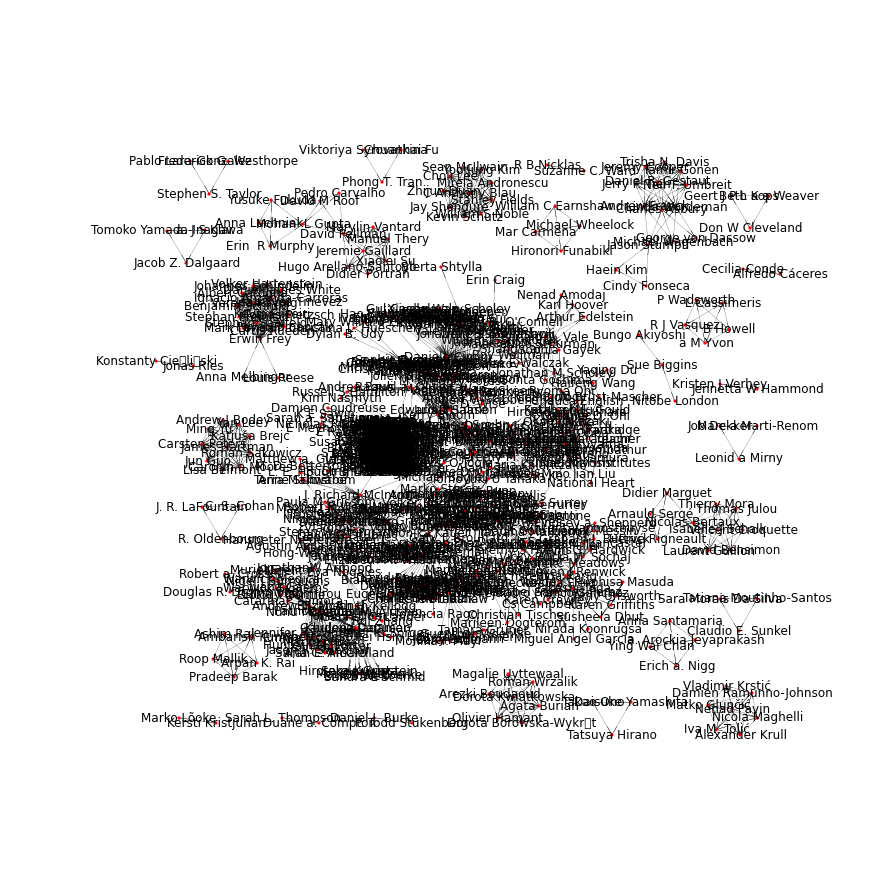

In [11]:
mat, g = create_graph(data)
fig = draw(g, font_size=8)

### Filter to remove all authors with less than 2 articles

In [12]:
data = raw_data.copy()
max_article_by_authors = 2

articles_by_authors = data.groupby('author_id').size()
authors_index = articles_by_authors[articles_by_authors >= max_article_by_authors].index
data = data.set_index('author_id').loc[authors_index].reset_index()

print_info(data)

You have 136 differents authors in 146 different articles


/home/hadim/local/conda/envs/st/lib/python3.4/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


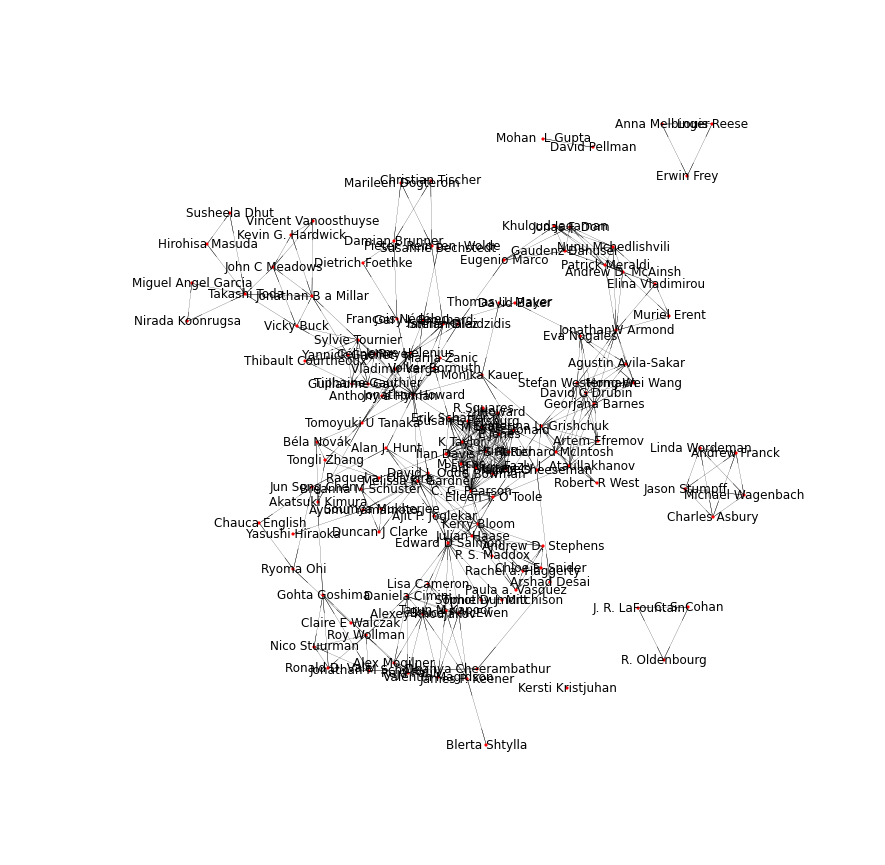

In [13]:
mat, g = create_graph(data)
fig = draw(g, font_size=12)

Save it as a GraphML file.

In [14]:
nx.write_graphml(g, os.path.join(os.environ['HOME'], "authors.graphml"))

### Filter to keep only principal investigator (last or before last author)

In [15]:
data = data[data.apply(lambda x: (x['authors_numbers'] - x['author_position']) <= 1, axis=1)]
print_info(data)

You have 84 differents authors in 138 different articles


/home/hadim/local/conda/envs/st/lib/python3.4/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


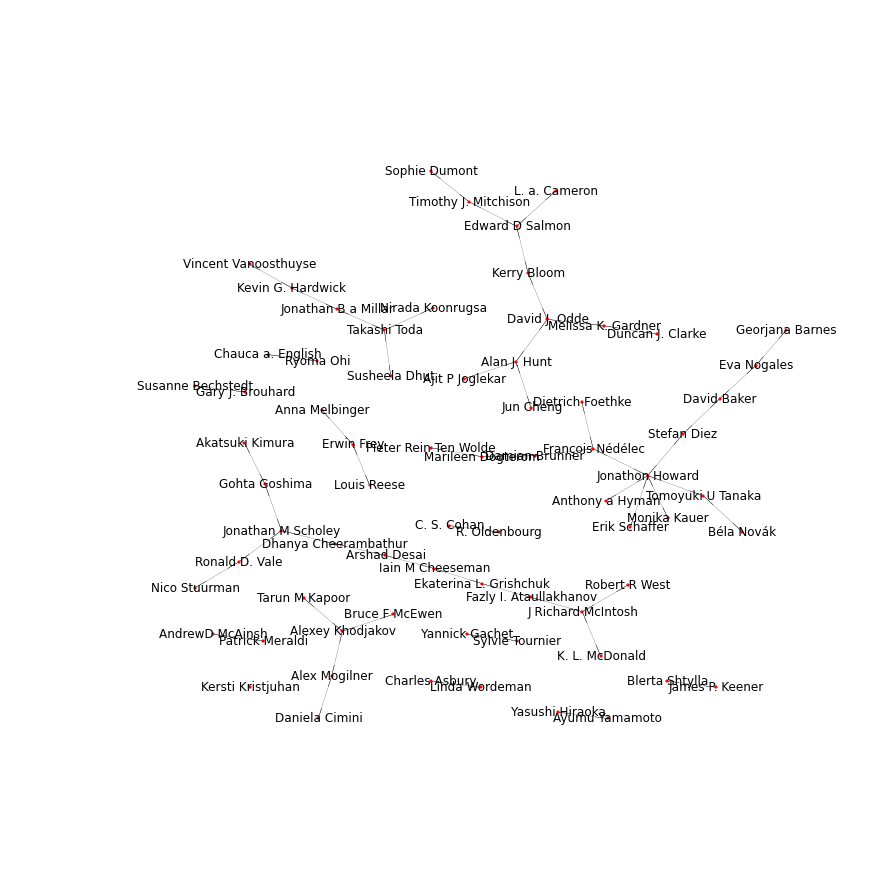

In [16]:
mat, g = create_graph(data)
fig = draw(g, font_size=12)

# Process data outside of Python

With the GraphML file (you can also export to others format, see http://networkx.github.io/documentation/latest/reference/readwrite.html), you can process the graph with others softwares (such as Cytoscape, Tulip, D3.js, etc).

### An example with Cytoscape

![cytoscape](cytoscape.png)